## <center>Wage Prediction Modelling For USA Computer Technology Occupations</center>

### Abstract
This paper investigates wage prediction models for computer technology occupations in the United States, employing a diverse set of predictors including age, gender, number of children in the household, employment class, education level, marital status, and citizenship status. The primary objective is to compare the performance between different models, from simple to complex, in predicting hourly wage for professionals in this sector. Four distinct models are considered, progressively incorporating additional predictors: a quadratic age model, a model adding gender and numnber of children, a model further incorporating employment class and education level and a model further accounting for marital and citizenship status. Through comparative analysis, I assess the predictive results of these models, seeking to identify the most effective model for wage estimation in computer technology occupations.

-----

In [1]:
%%capture
!pip install -r requirements.txt

In [2]:
%matplotlib inline

In [3]:
%%capture
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import patchworklib as pw

from py_helper_functions import *

from mizani.transforms import log_trans
from mizani.formatters import percent_format
from mizani.formatters import log_format

from stargazer import stargazer

### 1. Data

#### Data Preparation
The data in the paper is from the cps-earnings dataset at https://osf.io/g8p9j/. I then applied some filtering and transformations to end up with the working dataset. The filtering and transformations are as follows:
1. Get the raw dataset (N = 149,316)
2. Apply filters (N = 4,304):
    - Computer tech occupation codes from 1005 to 1107
    - Employee with high school diploma and above 
    - Minimum 20 working hours per week 
    - Hourly wage more than $1/hr
3. Transform some columns (N = 4,304):
    - Get hourly wage by dividing weekly wage by number of working hours
    - Create boolean variable for gender
    - Transform citizenship status text to numerical values
    - Transform employment class (public, private, self-employed,...) text to numerical values
    - Create dummy vairables for citizenship status, employment class, marital status and education level
    - Add the square of age for non-linear regression

The models in this paper use the hourly wage as the target variable. Other variables are used as predictors including:
- Age
- Square of Age
- Gender
- Number of children in the household
- Employment class
- Education level
- Marital status
- Citizenship status


In [4]:
# dictionary for citizenship status
citizenship_dict = {
    "Native, Born In US": 1,
    "Foreign Born, Not a US Citizen": 2,
    "Foreign Born, US Cit By Naturalization": 3,
    "Native, Born Abroad Of US Parent(s)": 4,
    "Native, Born in PR or US Outlying Area": 5
}

# dictionary for employment class
class_dict = {
    "Private, For Profit": 1,
    "Private, Nonprofit": 2,
    "Government - Federal": 3,
    "Government - State": 4,
    "Government - Local": 5
}

def get_cleaned_data(src: str) -> pd.DataFrame:
    '''
    This function takes a path to a csv file, cleans it and returns the cleaned dataframe
    :param src: path to file
    :return: dataframe with cleaned data
    '''
    df = pd.read_csv(src)
    
    # Filter the data for: 
    #   occ2012 between 1005 and 1107 (Tech occupations), 
    #   high school graduate and above,
    #   work week > 0, 
    #   work minimum 20hrs per week, 
    #   hourly wage >= 1
    comp_sample = df[(df['occ2012'] >= 1005)
                     & (df['occ2012'] <= 1107)
                     & (df['grade92'] >= 39) 
                     & (df['uhours'] >= 20) 
                     & (df['earnwke'] > 0)
                     & (df['earnwke']/df['uhours'] >= 1)].iloc[:, 1:]
    
    #drop the raw df
    del df
    
    # Add a column 'hourly_wage' to the DataFrame
    comp_sample['hourly_wage'] = (comp_sample['earnwke'] / comp_sample['uhours']).round(decimals=2)
    # add column female to have boolean for male or female
    comp_sample['female'] = comp_sample['sex'].apply(lambda x: 1 if x == 2 else 0)
    # add column for age squared
    comp_sample['agesq'] = np.power(comp_sample['age'], 2)
    # add column for citizen to have boolean value if worker has US citizenship
    comp_sample['citizenship_status_code'] = comp_sample['prcitshp'].apply(lambda x: citizenship_dict[x])
    # add column for occupation class code
    comp_sample['class_code'] = comp_sample['class'].apply(lambda x: class_dict[x])
    
    # create dummy variables
    comp_sample = pd.get_dummies(columns=['citizenship_status_code', 'marital', 'grade92', 'class_code'], data=comp_sample, prefix=['citizen', 'marital', 'edu', 'class'], drop_first=True, dtype=int)
    
    # round to 2 decimal places
    comp_sample = comp_sample.round(decimals=2)
    
    return comp_sample

In [5]:
# cleaned_df = get_cleaned_data('https://raw.githubusercontent.com/viethngn/Data_Analysis_3_ECBS5171/main/assignment1/morg-2014-emp.csv')
cleaned_df = get_cleaned_data('morg-2014-emp.csv')
cleaned_df.shape;

#### Data Exploration

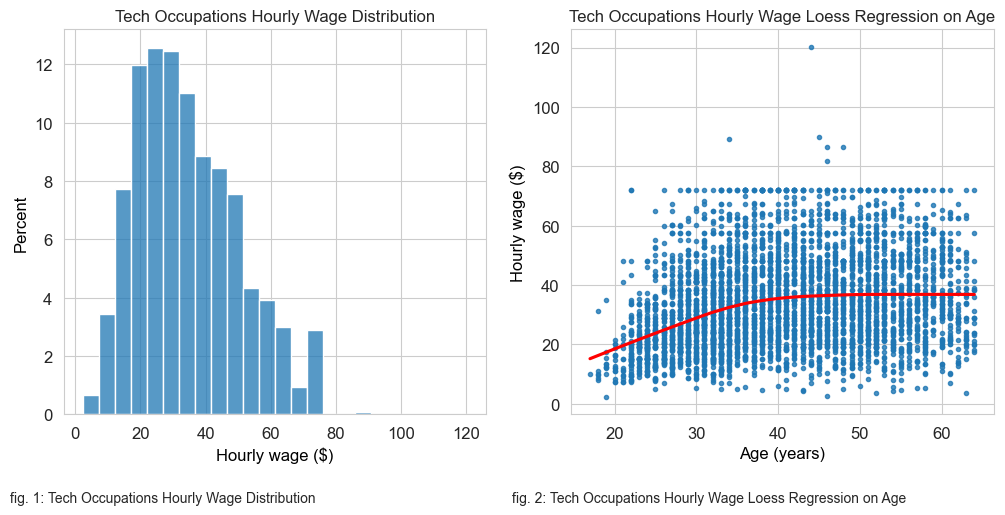

In [6]:
# figures for wage distribution and loess regression
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5))
sns.set(style="white")
fig1 = (sns.histplot(
    data = cleaned_df,
    x = 'hourly_wage', stat='percent', binwidth=5, ax=ax1))
fig1.set(title='Tech Occupations Hourly Wage Distribution', xlabel="Hourly wage ($)", ylabel="Percent")
ax1.text(-20, -3, 'fig. 1: Tech Occupations Hourly Wage Distribution', size=10)
fig2 = (sns.regplot(
    data = cleaned_df,
    x = 'age', y = 'hourly_wage', 
    marker= '.',
    fit_reg= True, lowess= True, line_kws={"color": "red"}, ax=ax2))
fig2.set(title='Tech Occupations Hourly Wage Loess Regression on Age', xlabel='Age (years)', ylabel='Hourly wage ($)')
ax2.text(7.5, -33, 'fig. 2: Tech Occupations Hourly Wage Loess Regression on Age', size=10)
fig.show()

From fig. 1, it is clear that the target variable hourly wage is left skewed. This means that the mean value of hourly wage is not the typical value. Within this paper, the models will assume that the mean is typical and will predict for the mean value. It is worth noting that normally this is not the case and there might be impacts on the prediction results made by the models.

In fig. 2, I construct the loess regression of hourly wage on age as the primary independent variable. The loess line shows a positive trend from age 15 to 35, then gradually flatten from 35 onward. There is a non-linear relationship between hourly wage and age. Thus, a square term is included in the subsequent model used for hourly wage prediction to represent this non-linearity.

### 2. Models
For this paper, I constructed four predictive models, from simple to complex, to try predicting the hourly wage for a professional in the computer technology sector. Each model is a linear regression with OLS method, where the target variable is hourly wage and the predictors as listed in the **Data** section above. 

In [7]:
### Cross validate OLS with combining sklearn k-fold cross validation and statsmodels ols formula
def cv_reg(formula, data, kfold, robustse=None):
    regression_list = []
    predicts_on_test = []
    rsquared = []
    rmse_list = []
    rmse_list_test = []

    # Calculating OLS for each fold

    for train_index, test_index in kfold.split(data):
        # print("TRAIN:", train_index, "TEST:", test_index)
        data_train, data_test = data.iloc[train_index, :], data.iloc[test_index, :]
        if robustse is None:
            model = smf.ols(formula, data=data_train).fit()
        else:
            model = smf.ols(formula, data=data_train).fit(cov_type=robustse)
        regression_list += [model]
        predicts_on_test += [model.predict(data_test)]
        rsquared += [model.rsquared]
        rmse_list += [rmse(data_train[formula.split("~")[0]], model.predict(data_train))]
        rmse_list_test += [rmse(data_test[formula.split("~")[0]], model.predict(data_test))]
    nvars = model.df_model

    return {
        "regressions": regression_list,
        "test_predict": predicts_on_test,
        "r2": rsquared,
        "rmse": rmse_list,
        "rmse_test": rmse_list_test,
        "nvars": nvars,
    }

def summarize_cv(cvlist, stat="rmse"):
    result = pd.DataFrame(
        {"Model" + str(x + 1): cvlist[x][stat] for x in range(len(cv_list))}
    )
    result["Resample"] = ["Fold" + str(x + 1) for x in range(len(cvlist[0]["rmse"]))]
    result = result.set_index("Resample")
    result = pd.concat([result, pd.DataFrame(result.mean(), columns=["Average"]).T])
    return result

In [8]:
# building regression formulas
reg_formulas = ["hourly_wage~age+agesq",
                "hourly_wage~age+agesq+female+ownchild",
                "hourly_wage~age+agesq+female+ownchild+" + '+'.join([col for col in cleaned_df.columns if 'class_' in col])
                + '+' + '+'.join([col for col in cleaned_df.columns if 'edu_' in col]),
                "hourly_wage~age+agesq+female+ownchild+" + '+'.join([col for col in cleaned_df.columns if 'class_' in col]) 
                + '+' + '+'.join([col for col in cleaned_df.columns if 'edu_' in col])
                + '+' + '+'.join([col for col in cleaned_df.columns if 'marital_' in col])
                + '+' + '+'.join([col for col in cleaned_df.columns if 'citizen_' in col])]
reg_formulas;

In [9]:
# define the number of folds
k = KFold(n_splits=5, shuffle=False, random_state=None)

# create 4 cross validations
cv1 = cv_reg(reg_formulas[0], cleaned_df, k, "HC1")
cv2 = cv_reg(reg_formulas[1], cleaned_df, k, "HC1")
cv3 = cv_reg(reg_formulas[2], cleaned_df, k, "HC1")
cv4 = cv_reg(reg_formulas[3], cleaned_df, k, "HC1")

cv_list = [cv1, cv2, cv3, cv4]

cv_summary = summarize_cv(cv_list).round(decimals=3)
cv_summary;

In [10]:
# create the regression models
reg1 = smf.ols(formula=reg_formulas[0], data=cleaned_df).fit(cov_type="HC1")
reg2 = smf.ols(formula=reg_formulas[1], data=cleaned_df).fit(cov_type="HC1")
reg3 = smf.ols(formula=reg_formulas[2], data=cleaned_df).fit(cov_type="HC1")
reg4 = smf.ols(formula=reg_formulas[3], data=cleaned_df).fit(cov_type="HC1")

# create the regression table
reg_list = [reg1, reg2, reg3, reg4]
bic = [round(x.bic, 2) for x in reg_list]
rmse_all = [round(rmse(cleaned_df[reg_formulas[x].split("~")[0]], reg_list[x].predict()), 3) for x in range(len(reg_list))]
rmse_kfold = (cv_summary.loc['Average']).tolist()
sg = stargazer.Stargazer(reg_list)
sg.covariate_order(
    [
        'Intercept',
        'age',
        'agesq',
        'female',
        'ownchild'
    ]
)
sg.rename_covariates({
    'age': "Age",
    'agesq': "Squared of Age",
    'female': "is Female",
    'ownchild': "Number of children"
})
sg.add_line("Employment class (4 variables)", ["", "", "Yes", "Yes"])
sg.add_line("Education level (7 variables)", ["", "", "Yes", "Yes"])
sg.add_line("Marital status (6 variables)", ["", "", "", "Yes"])
sg.add_line("Citizenship status (4 variables)", ["", "", "", "Yes"])
sg.add_line('BIC', bic, location=stargazer.LineLocation.FOOTER_BOTTOM)
sg.add_line('RMSE', rmse_all, location=stargazer.LineLocation.FOOTER_BOTTOM)
sg.add_line('CV RMSE', rmse_kfold, location=stargazer.LineLocation.FOOTER_BOTTOM)
sg

**Model 1 - Hourly wage on age and square of age**

$Hourly\ wage = \beta_0 + \beta_1\times age + \beta_2\times age^2 + \epsilon$

**Model 2 - Extension of model 1 with gender and number of children**

$Hourly\ wage = \beta_0 + \beta_1\times age + \beta_2\times age^2 + \beta_3\times isFemale + \beta_4\times numberChildren + \epsilon$

**Model 3 - Extension of model 2 with employment class and education level**

$Hourly\ wage = \beta_0 + \beta_1\times age + \beta_2\times age^2 $
$+ \beta_3\times isFemale + \beta_4\times numberChildren $
$+ \beta_i\times C(employmentClass) + \beta_k\times C(educationLevel) + \epsilon$

**Model 4 - Extension of model 3 with marital status and citizenship status**

$Hourly\ wage = \beta_0 + \beta_1\times age + \beta_2\times age^2 $
$+ \beta_3\times isFemale + \beta_4\times numberChildren $
$+ \beta_i\times C(employmentClass) + \beta_k\times C(educationLevel) $ 
$+ \beta_j\times C(maritalStatus) + \beta_l\times C(citizenshipStatus) + \epsilon$

In [11]:
# get a sample for test prediction
test = cleaned_df.iloc[200].to_frame().T
test = test.infer_objects()

# building the PI table for all models
alpha = 0.2
pi_list = []

for reg in reg_list:
    pi_list.append(reg.get_prediction(test).summary_frame(alpha=alpha))

pd.DataFrame(
    {
        " ": ["Predicted", "PI_low(80%)", "PI_high(80%)"],
        "Model1": pi_list[0][["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
        "Model2": pi_list[1][["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
        "Model3": pi_list[2][["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
        "Model4": pi_list[3][["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
    }
).set_index(" ")

,Model1,Model2,Model3,Model4
,,,,
Predicted,29.450556,26.447708,29.429267,28.715455
PI_low(80%),10.387172,7.646103,11.706046,10.929622
PI_high(80%),48.513939,45.249313,47.152489,46.501288


In [12]:
# create the regression models
reg1 = smf.ols(formula=reg_formulas[0], data=cleaned_df).fit(cov_type="HC1")
reg2 = smf.ols(formula=reg_formulas[1], data=cleaned_df).fit(cov_type="HC1")
reg3 = smf.ols(formula=reg_formulas[2], data=cleaned_df).fit(cov_type="HC1")
reg4 = smf.ols(formula=reg_formulas[3], data=cleaned_df).fit(cov_type="HC1")

# create the regression table
reg_list = [reg1, reg2, reg3, reg4]
bic = [round(x.bic, 2) for x in reg_list]
rmse_all = [round(rmse(cleaned_df[reg_formulas[x].split("~")[0]], reg_list[x].predict()), 3) for x in range(len(reg_list))]
rmse_kfold = (cv_summary.loc['Average']).tolist()
sg = stargazer.Stargazer(reg_list)
sg.add_line('BIC', bic, location=stargazer.LineLocation.FOOTER_BOTTOM)
sg.add_line('RMSE', rmse_all, location=stargazer.LineLocation.FOOTER_BOTTOM)
sg.add_line('CV RMSE', rmse_kfold, location=stargazer.LineLocation.FOOTER_BOTTOM)
sg